In [33]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import math
from collections import defaultdict
from textwrap import wrap
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OrdinalEncoder

import wandb

import nltk.data
from nltk.tokenize import sent_tokenize
from nltk.corpus import alpino

from imblearn.over_sampling import RandomOverSampler

### Configure

Libraries settings

In [34]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Model settings

In [35]:
PRE_TRAINED_MODEL_NAME = 'wietsedv/bert-base-dutch-cased'
LEN_SENTS = 100

Wandb settings to track experiment

In [36]:
#wandb.init(project="histaware")
wandb.config.dataset = "edo_1990s"

### Import data

In [37]:
gas = pd.read_csv("sentiment/edo_1990s_gas_labeled.csv")
gas = gas[gas.energy == "Y"]
gas = gas[gas.sentiment != None]

In [38]:
olie = pd.read_csv("sentiment/edo_1990s_olie_labeled.csv")
olie = olie[olie.energy == "Y"]
olie = olie[olie.sentiment != None]

In [39]:
kool = pd.read_csv("sentiment/edo_1990s_kool_labeled.csv")
kool = kool[kool.energy == "Y"]
kool = kool[kool.sentiment_coal != None]
kool.drop(["sentiment", "sentiment_gas", "sentiment_oil"], axis=1, inplace=True)
kool.rename(columns = {"sentiment_coal": "sentiment"}, inplace=True)

In [40]:
df = pd.concat([gas, olie, kool], ignore_index=True)
df.text.replace('', np.nan, inplace=True)
df.dropna(subset=['text'], inplace=True)
df.sentiment.replace('', np.nan, inplace=True)
df.dropna(subset=['sentiment'], inplace=True)
df.shape

(1066, 24)

### Labels

In [41]:
cleanup_sentiment = {"sentiment": {"VN": 1, "NG": 2, "NE": 3, "PO": 4, "VP": 5}}
df = df.replace(cleanup_sentiment)

Plot

In [42]:
#ax = sns.countplot(df.sentiment)
#plt.xlabel('review sentiment')

Reduce from 5 labels to 3 because of lack of labels

In [43]:
def to_sentiment(rating):
    rating = int(rating)
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2

df['sentiment'] = df.sentiment.apply(to_sentiment)

Plot result reduction of labels

In [44]:
#ax = sns.countplot(df.sentiment)
#plt.xlabel('review sentiment')

### Split text and explode

In [45]:
def unite(l, n):
    """Unite sentences previously split using nltk.tokenize."""
    count = []
    chunks = []
    sents = []
    for s in l:
        count.append(len(s.split()))
    value = 0
    prev_idx = 0
    for i in range(0, len(count)):
        if value == 0:
            value = value + count[i]
        elif (i+1 == len(count)):
            chunks.append(l[prev_idx:i])
            value = 0
        elif value >= n:
            chunks.append(l[prev_idx:i])
            prev_idx = i
            value = 0
        else:
             value = value + count[i]
    for c in chunks:
        sents.append(' '.join(c))
    return(sents)

In [46]:
def splitter(s, n):
    """Split sentences only using the number of words."""
    pieces = s.split()
    return [" ".join(pieces[i:i+n]) for i in range(0, len(pieces), n)]

In [47]:
df["text_split"] = df["text"].apply(sent_tokenize)
df["text_split"] = df["text_split"].apply(unite, n = LEN_SENTS)
df.text_split.replace([], np.nan, inplace=True)
df.dropna(subset=['text_split'], inplace=True)
# Cancel all text_split == 0
df.drop(df[df.text_split.map(len) == 0].index, inplace=True)
# Currently not splitting the cleaned sentences
#df["text_clean_split"] = df["text_clean"].apply(splitter, n = LEN_SENTS)

### Load Pre-trained BERT model

In [48]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

### Verify the max tokens length in text_split

In [49]:
MAX_LEN = 0
def max_len(x):
    lengths = []
    for i in x:
        lengths.append(len(tokenizer.encode(i.split())))
    res = max(lengths)
    return(res)
    
temp = df["text_split"].apply(max_len)
MAX_LEN = max(temp)
MAX_LEN

361

In [50]:
df = df.explode('text_split')
df.shape

(2342, 25)

In [51]:
token_lens = []
for txt in df.text_split:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


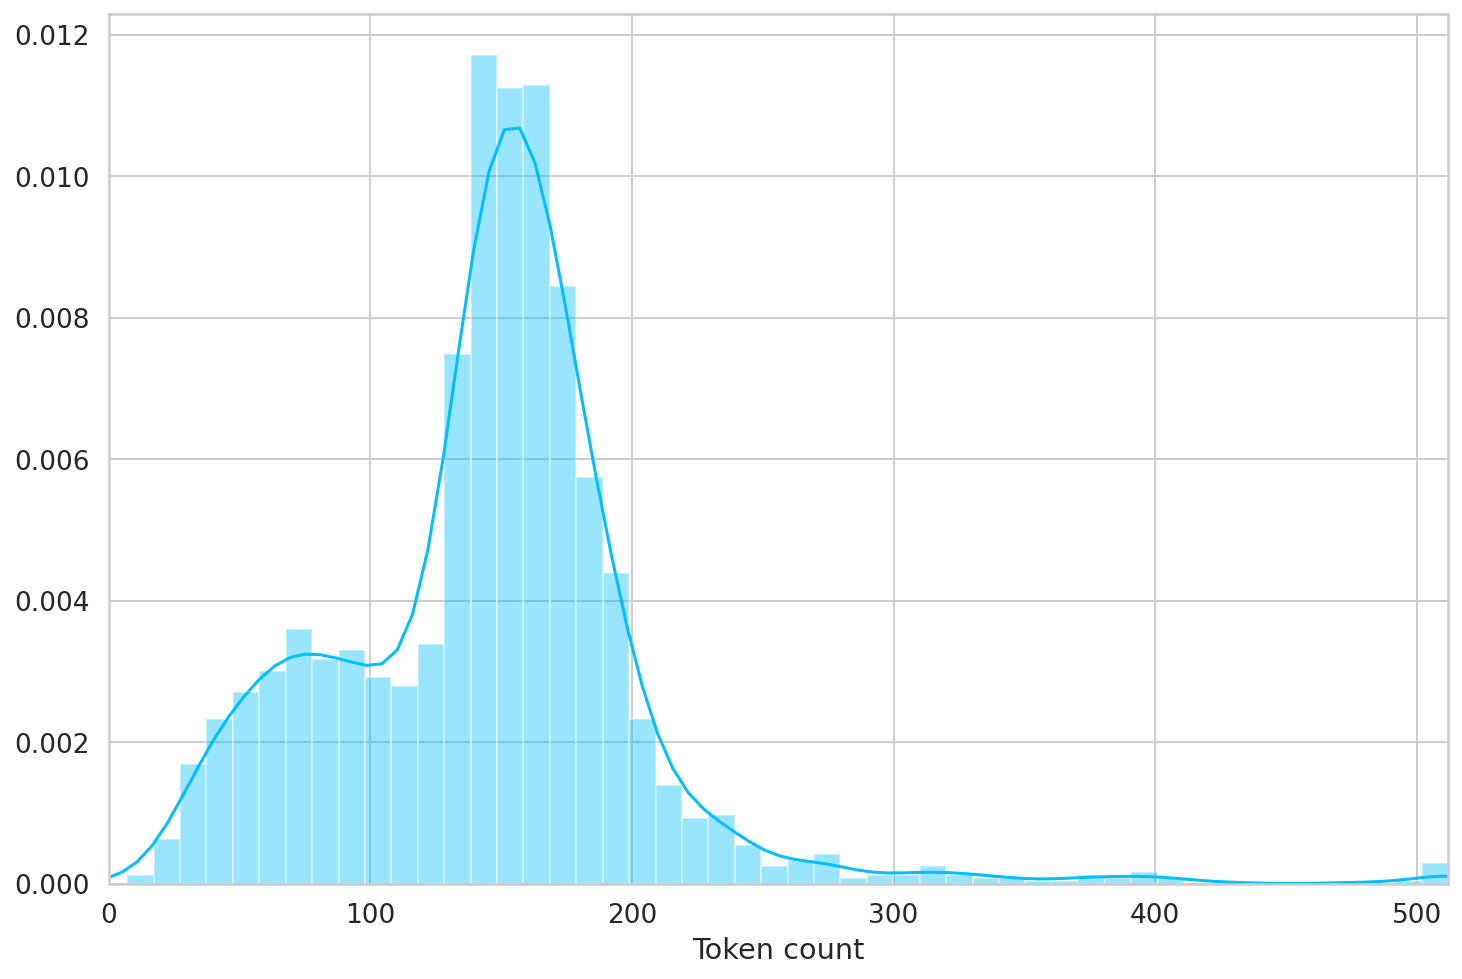

In [52]:
sns.distplot(token_lens)
plt.xlim([0, 512]);
plt.xlabel('Token count');

### Train test and validation split

In [53]:
df_train, df_test = train_test_split(
  df,
  test_size=0.25,
  random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

### Dataset and Data Loader

In [65]:
class HADataset(Dataset):
    # Characterizes a dataset for Pytorch
    def __init__(self, articles, labels, tokenizer, max_len):
        # Initialization
        self.articles = articles
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        # Total number of articles
        return len(self.articles)

    def __getitem__(self, item):
        # Generates one sample of the data/article
        article = str(self.articles[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            article,
            add_special_tokens=True,
            #padding='max_length',
            truncation=True, # there should be no need of this as all p should be smaller than this
            max_length=self.max_len,
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
          'article_text': article,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'labels': torch.tensor(label, dtype=torch.long)
        }

In [66]:
def create_data_loader(df, tokenizer, batch_size, num_workers):
    ds = HADataset(
        articles=df.text_split.to_numpy(),
        labels=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=MAX_LEN
      )
    
    return DataLoader(
        ds,
        batch_size,
        num_workers
      )

In [67]:
# Parameters
batch_size = 8
num_workers = 0
max_epochs = 100

In [78]:
# Create dataloaders
#train_data_loader = create_data_loader(df_train, tokenizer, batch_size, num_workers)
#val_data_loader = create_data_loader(df_val, tokenizer, batch_size, num_workers)
#test_data_loader = create_data_loader(df_test, tokenizer, batch_size, num_workers)

MAX_LEN = 512 # rewriting value computed above

# Create Dataset (?)
dataset_train = HADataset(
        articles=df_train.text_split.to_numpy(),
        labels=df_train.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=MAX_LEN)

dataset_val = HADataset(
        articles=df_val.text_split.to_numpy(),
        labels=df_val.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=MAX_LEN)

### Modified huggingface hyperparameters tuning

In [79]:
from transformers import (AutoModel, AutoTokenizer, AutoConfig,
                          Trainer, TrainingArguments)

config = AutoConfig.from_pretrained(PRE_TRAINED_MODEL_NAME)
#print(config)
bert_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
#print(bert_model)
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
#print(tokenizer)

PreTrainedTokenizer(name_or_path='wietsedv/bert-base-dutch-cased', vocab_size=30000, model_max_len=512, is_fast=False, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


In [80]:
training_args = TrainingArguments(
    output_dir = "hist-aware/notebooks/models",
    overwrite_output_dir = False,
    evaluation_strategy="steps",
    per_device_train_batch_size=8, # default is 8
    per_device_eval_batch_size=8,
    logging_dir="hist-aware/notebooks/logging",
    eval_steps=500,
    seed=RANDOM_SEED,
    label_names="labels", # check this
    disable_tqdm=False # check this
)

In [ ]:
def model_init():
    return AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=True)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.argmax(axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# Evaluate during training and a bit more often
# than the default to be able to prune bad trials early.
# Disabling tqdm is a matter of preference.
trainer = Trainer(
    args=training_args,
    tokenizer=tokenizer,
    train_dataset=dataset_train,
    eval_dataset=dataset_val,
    model_init=model_init,
    compute_metrics=compute_metrics,
)

# Defaut objective is the sum of all metrics
# when metrics are provided, so we have to maximize it.
trainer.hyperparameter_search(
    direction="maximize", 
    backend="ray", 
    n_trials=100, # deafult 100
    # n_jobs=2  # number of parallel jobs, if multiple GPUs
)

2021-02-10 18:16:33,865	WARNING worker.py:1034 -- Warning: The actor ImplicitFunc has size 439034169 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2021-02-10 18:16:34,500	WARNING util.py:141 -- The `start_trial` operation took 8.913 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 12.8/39.3 GiB
Using FIFO scheduling algorithm.
Resources requested: 1/5 CPUs, 1/1 GPUs, 0.0/20.95 GiB heap, 0.0/7.23 GiB objects (0/1.0 accelerator_type:RTX)
Result logdir: /home/leonardovida/ray_results/_objective_2021-02-10_18-16-19
Number of trials: 1/100 (1 RUNNING)
+------------------------+----------+-------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc   |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-------+-----------------+--------------------+-------------------------------+---------|
| _objective_1420e_00000 | RUNNING  |       |     5.61152e-06 |                  4 |                             4 | 38.0779 |
+------------------------+----------+-------+-----------------+--------------------+-------------------------------+---------+




2021-02-10 18:16:43,827	WARNING worker.py:1034 -- The actor or task with ID ffffffffffffffff205ffc5701000000 cannot be scheduled right now. It requires {GPU: 1.000000}, {CPU: 1.000000} for placement, but this node only has remaining {accelerator_type:RTX: 1.000000}, {node:192.168.1.142: 1.000000}, {CPU: 4.000000}, {object_store_memory: 7.226562 GiB}, {memory: 20.947266 GiB}. In total there are 0 pending tasks and 1 pending actors on this node. This is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increase the resources available to this Ray cluster. You can ignore this message if this Ray cluster is expected to auto-scale.
(pid=19429) 2021-02-10 18:16:46.689090: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
(pid=19429) 2021-02-10 18:16:46.689146: I tensorflow/str

(pid=19429) 
Result for _objective_1420e_00000:
  {}
  
== Status ==
Memory usage on this node: 12.7/39.3 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/5 CPUs, 0/1 GPUs, 0.0/20.95 GiB heap, 0.0/7.23 GiB objects (0/1.0 accelerator_type:RTX)
Result logdir: /home/leonardovida/ray_results/_objective_2021-02-10_18-16-19
Number of trials: 2/100 (1 ERROR, 1 PENDING)
+------------------------+----------+-------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc   |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-------+-----------------+--------------------+-------------------------------+---------|
| _objective_1420e_00001 | PENDING  |       |     2.91064e-05 |                  2 |                             8 | 24.3477 |
| _objective_1420e_00000 | ERROR    |       |     5.61152e-06 |                  4 |                             4 |

(pid=19429) wandb: Waiting for W&B process to finish, PID 19458
(pid=19429) wandb: Program ended successfully.
(pid=19429) wandb: - 0.00MB of 0.00MB uploaded (0.00MB deduped)
wandb:                                                                                
(pid=19429) wandb: Find user logs for this run at: /home/leonardovida/ray_results/_objective_2021-02-10_18-16-19/_objective_1420e_00000_0_learning_rate=5.6115e-06,num_train_epochs=4,per_device_train_batch_size=4,seed=38.078_2021-02-10_18-16-28/wandb/run-20210210_181654-7bvcikji/logs/debug.log
(pid=19429) wandb: Find internal logs for this run at: /home/leonardovida/ray_results/_objective_2021-02-10_18-16-19/_objective_1420e_00000_0_learning_rate=5.6115e-06,num_train_epochs=4,per_device_train_batch_size=4,seed=38.078_2021-02-10_18-16-28/wandb/run-20210210_181654-7bvcikji/logs/debug-internal.log
(pid=19429) wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
(pid=19429) wandb: 
(pid=19429) wandb: S

(pid=19429) 


2021-02-10 18:17:05,218	WARNING util.py:141 -- The `start_trial` operation took 9.351 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.4/39.3 GiB
Using FIFO scheduling algorithm.
Resources requested: 1/5 CPUs, 1/1 GPUs, 0.0/20.95 GiB heap, 0.0/7.23 GiB objects (0/1.0 accelerator_type:RTX)
Result logdir: /home/leonardovida/ray_results/_objective_2021-02-10_18-16-19
Number of trials: 2/100 (1 ERROR, 1 RUNNING)
+------------------------+----------+-------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc   |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-------+-----------------+--------------------+-------------------------------+---------|
| _objective_1420e_00001 | RUNNING  |       |     2.91064e-05 |                  2 |                             8 | 24.3477 |
| _objective_1420e_00000 | ERROR    |       |     5.61152e-06 |                  4 |                             4 | 38.0779 |
+------------------------+----------+-------+-

(pid=19491) 2021-02-10 18:17:07.760606: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
(pid=19491) 2021-02-10 18:17:07.760659: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
(pid=19491) wandb: Currently logged in as: leonardovida (use `wandb login --relogin` to force relogin)
(pid=19491) wandb: wandb version 0.10.18 is available!  To upgrade, please run:
(pid=19491) wandb:  $ pip install wandb --upgrade
(pid=19491) wandb: Tracking run with wandb version 0.10.12
(pid=19491) wandb: Syncing run hist-aware/notebooks/models
(pid=19491) wandb: ⭐️ View project at https://wandb.ai/leonardovida/huggingface
(pid=19491) wandb: 🚀 View run at https://wandb.ai/leonardovida/huggingface/runs/15uqkcaz
(pid=19491) wandb: Run data is saved locally in /home/leonardovida/r

(pid=19491) 
Result for _objective_1420e_00001:
  {}
  
== Status ==
Memory usage on this node: 13.1/39.3 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/5 CPUs, 0/1 GPUs, 0.0/20.95 GiB heap, 0.0/7.23 GiB objects (0/1.0 accelerator_type:RTX)
Result logdir: /home/leonardovida/ray_results/_objective_2021-02-10_18-16-19
Number of trials: 3/100 (2 ERROR, 1 PENDING)
+------------------------+----------+-------+-----------------+--------------------+-------------------------------+----------+
| Trial name             | status   | loc   |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |
|------------------------+----------+-------+-----------------+--------------------+-------------------------------+----------|
| _objective_1420e_00002 | PENDING  |       |     2.05134e-06 |                  4 |                            32 |  7.08379 |
| _objective_1420e_00000 | ERROR    |       |     5.61152e-06 |                  4 |                            

(pid=19491) wandb: Waiting for W&B process to finish, PID 19516
(pid=19491) wandb: Program ended successfully.
(pid=19491) wandb: - 0.00MB of 0.00MB uploaded (0.00MB deduped)
wandb:                                                                                
(pid=19491) wandb: Find user logs for this run at: /home/leonardovida/ray_results/_objective_2021-02-10_18-16-19/_objective_1420e_00001_1_learning_rate=2.9106e-05,num_train_epochs=2,per_device_train_batch_size=8,seed=24.348_2021-02-10_18-16-59/wandb/run-20210210_181715-15uqkcaz/logs/debug.log
(pid=19491) wandb: Find internal logs for this run at: /home/leonardovida/ray_results/_objective_2021-02-10_18-16-19/_objective_1420e_00001_1_learning_rate=2.9106e-05,num_train_epochs=2,per_device_train_batch_size=8,seed=24.348_2021-02-10_18-16-59/wandb/run-20210210_181715-15uqkcaz/logs/debug-internal.log
(pid=19491) wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
(pid=19491) wandb: 
(pid=19491) wandb: S

(pid=19491) 


2021-02-10 18:17:26,025	WARNING util.py:141 -- The `start_trial` operation took 9.132 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.4/39.3 GiB
Using FIFO scheduling algorithm.
Resources requested: 1/5 CPUs, 1/1 GPUs, 0.0/20.95 GiB heap, 0.0/7.23 GiB objects (0/1.0 accelerator_type:RTX)
Result logdir: /home/leonardovida/ray_results/_objective_2021-02-10_18-16-19
Number of trials: 3/100 (2 ERROR, 1 RUNNING)
+------------------------+----------+-------+-----------------+--------------------+-------------------------------+----------+
| Trial name             | status   | loc   |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |
|------------------------+----------+-------+-----------------+--------------------+-------------------------------+----------|
| _objective_1420e_00002 | RUNNING  |       |     2.05134e-06 |                  4 |                            32 |  7.08379 |
| _objective_1420e_00000 | ERROR    |       |     5.61152e-06 |                  4 |                             4 | 38.0779  |
| _objective_1420e_00001 | ERROR    |    

(pid=19546) 2021-02-10 18:17:28.588348: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
(pid=19546) 2021-02-10 18:17:28.588397: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
(pid=19546) wandb: Currently logged in as: leonardovida (use `wandb login --relogin` to force relogin)
(pid=19546) wandb: wandb version 0.10.18 is available!  To upgrade, please run:
(pid=19546) wandb:  $ pip install wandb --upgrade
(pid=19546) wandb: Tracking run with wandb version 0.10.12
(pid=19546) wandb: Syncing run hist-aware/notebooks/models
(pid=19546) wandb: ⭐️ View project at https://wandb.ai/leonardovida/huggingface
(pid=19546) wandb: 🚀 View run at https://wandb.ai/leonardovida/huggingface/runs/21wlibu2
(pid=19546) wandb: Run data is saved locally in /home/leonardovida/r

(pid=19546) 
Result for _objective_1420e_00002:
  {}
  
== Status ==
Memory usage on this node: 12.7/39.3 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/5 CPUs, 0/1 GPUs, 0.0/20.95 GiB heap, 0.0/7.23 GiB objects (0/1.0 accelerator_type:RTX)
Result logdir: /home/leonardovida/ray_results/_objective_2021-02-10_18-16-19
Number of trials: 4/100 (3 ERROR, 1 PENDING)
+------------------------+----------+-------+-----------------+--------------------+-------------------------------+----------+
| Trial name             | status   | loc   |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |
|------------------------+----------+-------+-----------------+--------------------+-------------------------------+----------|
| _objective_1420e_00003 | PENDING  |       |     1.30667e-06 |                  5 |                             4 | 34.7809  |
| _objective_1420e_00000 | ERROR    |       |     5.61152e-06 |                  4 |                            

(pid=19546) wandb: Waiting for W&B process to finish, PID 19571
(pid=19546) wandb: Program ended successfully.
(pid=19546) wandb: - 0.00MB of 0.00MB uploaded (0.00MB deduped)
wandb:                                                                                
(pid=19546) wandb: Find user logs for this run at: /home/leonardovida/ray_results/_objective_2021-02-10_18-16-19/_objective_1420e_00002_2_learning_rate=2.0513e-06,num_train_epochs=4,per_device_train_batch_size=32,seed=7.0838_2021-02-10_18-17-19/wandb/run-20210210_181736-21wlibu2/logs/debug.log
(pid=19546) wandb: Find internal logs for this run at: /home/leonardovida/ray_results/_objective_2021-02-10_18-16-19/_objective_1420e_00002_2_learning_rate=2.0513e-06,num_train_epochs=4,per_device_train_batch_size=32,seed=7.0838_2021-02-10_18-17-19/wandb/run-20210210_181736-21wlibu2/logs/debug-internal.log
(pid=19546) wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
(pid=19546) wandb: 
(pid=19546) wandb:

(pid=19546) 


2021-02-10 18:17:46,973	WARNING util.py:141 -- The `start_trial` operation took 9.284 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.4/39.3 GiB
Using FIFO scheduling algorithm.
Resources requested: 1/5 CPUs, 1/1 GPUs, 0.0/20.95 GiB heap, 0.0/7.23 GiB objects (0/1.0 accelerator_type:RTX)
Result logdir: /home/leonardovida/ray_results/_objective_2021-02-10_18-16-19
Number of trials: 4/100 (3 ERROR, 1 RUNNING)
+------------------------+----------+-------+-----------------+--------------------+-------------------------------+----------+
| Trial name             | status   | loc   |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |
|------------------------+----------+-------+-----------------+--------------------+-------------------------------+----------|
| _objective_1420e_00003 | RUNNING  |       |     1.30667e-06 |                  5 |                             4 | 34.7809  |
| _objective_1420e_00000 | ERROR    |       |     5.61152e-06 |                  4 |                             4 | 38.0779  |
| _objective_1420e_00001 | ERROR    |    

(pid=19623) 2021-02-10 18:17:49.540350: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
(pid=19623) 2021-02-10 18:17:49.540399: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
(pid=19623) wandb: Currently logged in as: leonardovida (use `wandb login --relogin` to force relogin)
(pid=19623) wandb: wandb version 0.10.18 is available!  To upgrade, please run:
(pid=19623) wandb:  $ pip install wandb --upgrade
(pid=19623) wandb: Tracking run with wandb version 0.10.12
(pid=19623) wandb: Syncing run hist-aware/notebooks/models
(pid=19623) wandb: ⭐️ View project at https://wandb.ai/leonardovida/huggingface
(pid=19623) wandb: 🚀 View run at https://wandb.ai/leonardovida/huggingface/runs/157dh8ll
(pid=19623) wandb: Run data is saved locally in /home/leonardovida/r

(pid=19623) 
Result for _objective_1420e_00003:
  {}
  
== Status ==
Memory usage on this node: 12.7/39.3 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/5 CPUs, 0/1 GPUs, 0.0/20.95 GiB heap, 0.0/7.23 GiB objects (0/1.0 accelerator_type:RTX)
Result logdir: /home/leonardovida/ray_results/_objective_2021-02-10_18-16-19
Number of trials: 5/100 (4 ERROR, 1 PENDING)
+------------------------+----------+-------+-----------------+--------------------+-------------------------------+----------+
| Trial name             | status   | loc   |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |
|------------------------+----------+-------+-----------------+--------------------+-------------------------------+----------|
| _objective_1420e_00004 | PENDING  |       |     1.59305e-05 |                  3 |                             4 | 28.6148  |
| _objective_1420e_00000 | ERROR    |       |     5.61152e-06 |                  4 |                            

(pid=19623) wandb: Waiting for W&B process to finish, PID 19966
(pid=19623) wandb: Program ended successfully.
(pid=19623) wandb: - 0.00MB of 0.00MB uploaded (0.00MB deduped)
wandb:                                                                                
(pid=19623) wandb: Find user logs for this run at: /home/leonardovida/ray_results/_objective_2021-02-10_18-16-19/_objective_1420e_00003_3_learning_rate=1.3067e-06,num_train_epochs=5,per_device_train_batch_size=4,seed=34.781_2021-02-10_18-17-40/wandb/run-20210210_181757-157dh8ll/logs/debug.log
(pid=19623) wandb: Find internal logs for this run at: /home/leonardovida/ray_results/_objective_2021-02-10_18-16-19/_objective_1420e_00003_3_learning_rate=1.3067e-06,num_train_epochs=5,per_device_train_batch_size=4,seed=34.781_2021-02-10_18-17-40/wandb/run-20210210_181757-157dh8ll/logs/debug-internal.log
(pid=19623) wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
(pid=19623) wandb: 
(pid=19623) wandb: S

(pid=19623) 


2021-02-10 18:18:07,864	WARNING util.py:141 -- The `start_trial` operation took 9.345 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.4/39.3 GiB
Using FIFO scheduling algorithm.
Resources requested: 1/5 CPUs, 1/1 GPUs, 0.0/20.95 GiB heap, 0.0/7.23 GiB objects (0/1.0 accelerator_type:RTX)
Result logdir: /home/leonardovida/ray_results/_objective_2021-02-10_18-16-19
Number of trials: 5/100 (4 ERROR, 1 RUNNING)
+------------------------+----------+-------+-----------------+--------------------+-------------------------------+----------+
| Trial name             | status   | loc   |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |
|------------------------+----------+-------+-----------------+--------------------+-------------------------------+----------|
| _objective_1420e_00004 | RUNNING  |       |     1.59305e-05 |                  3 |                             4 | 28.6148  |
| _objective_1420e_00000 | ERROR    |       |     5.61152e-06 |                  4 |                             4 | 38.0779  |
| _objective_1420e_00001 | ERROR    |    

(pid=19998) 2021-02-10 18:18:10.396351: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
(pid=19998) 2021-02-10 18:18:10.396404: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
(pid=19998) wandb: Currently logged in as: leonardovida (use `wandb login --relogin` to force relogin)
(pid=19998) wandb: wandb version 0.10.18 is available!  To upgrade, please run:
(pid=19998) wandb:  $ pip install wandb --upgrade
(pid=19998) wandb: Tracking run with wandb version 0.10.12
(pid=19998) wandb: Syncing run hist-aware/notebooks/models
(pid=19998) wandb: ⭐️ View project at https://wandb.ai/leonardovida/huggingface
(pid=19998) wandb: 🚀 View run at https://wandb.ai/leonardovida/huggingface/runs/2n3614iy
(pid=19998) wandb: Run data is saved locally in /home/leonardovida/r

(pid=19998) 
Result for _objective_1420e_00004:
  {}
  
== Status ==
Memory usage on this node: 12.7/39.3 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/5 CPUs, 0/1 GPUs, 0.0/20.95 GiB heap, 0.0/7.23 GiB objects (0/1.0 accelerator_type:RTX)
Result logdir: /home/leonardovida/ray_results/_objective_2021-02-10_18-16-19
Number of trials: 6/100 (5 ERROR, 1 PENDING)
+------------------------+----------+-------+-----------------+--------------------+-------------------------------+----------+
| Trial name             | status   | loc   |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |
|------------------------+----------+-------+-----------------+--------------------+-------------------------------+----------|
| _objective_1420e_00005 | PENDING  |       |     1.09943e-06 |                  2 |                            16 | 38.8265  |
| _objective_1420e_00000 | ERROR    |       |     5.61152e-06 |                  4 |                            

(pid=19998) wandb: Waiting for W&B process to finish, PID 20023
(pid=19998) wandb: Program ended successfully.
(pid=19998) wandb: - 0.00MB of 0.00MB uploaded (0.00MB deduped)


In [ ]:
best_trial = trainer.hyperparameter_search(
    direction="maximize",
    backend="ray",
    # Choose among many libraries:
    # https://docs.ray.io/en/latest/tune/api_docs/suggestion.html
    search_alg=HyperOptSearch(),
    # Choose among schedulers:
    # https://docs.ray.io/en/latest/tune/api_docs/schedulers.html
    scheduler=AsyncHyperBand())